In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import os
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
sns.set_style('whitegrid')
%matplotlib inline
# import warnings
# warnings.filterwarnings('ignore')
from keras.layers import Input
from keras.models import Model
from keras.layers import Dense
from keras.optimizers import Adam
#from generator import DataGenerator
import keras

import matplotlib.patches as patches

from sklearn.metrics import roc_auc_score
from PIL import Image
from tqdm.auto import tqdm
from typing import Dict
from pathlib import Path
import logging
import time
from prettytable import PrettyTable
from copy import deepcopy

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.models import densenet121
from torch.optim import Adam, lr_scheduler
import torchvision.transforms as tfms
import torchvision.transforms.functional as T

import albumentations as A
from albumentations.pytorch import ToTensorV2

In [2]:
class CFG:
    CLASS_NAMES = [
        "Atelectasis",
        "Cardiomegaly",
        "Effusion",
        "Infiltration",
        "Mass",
        "Nodule",
        "Pneumonia",
        "Pneumothorax",
        "Consolidation",
        "Edema",
        "Emphysema",
        "Fibrosis",
        "Pleural_Thickening",
        "Hernia",
    ]
    BEST_MODEL_PATH = "models/best_model.pt"
    EPOCHS = 5
    DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    INTERVAL = 10

In [3]:
CFG.DEVICE

device(type='cpu')

In [4]:
data = pd.read_csv(r'C:\Users\mikha\Desktop\Python IA RaioX\Data_Entry_2017_v2020.csv')
data.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168


In [5]:
data = data[['Image Index', 'Finding Labels']]

In [6]:
data.head()

,Image Index,Finding Labels
0,00000001_000.png,Cardiomegaly
1,00000001_001.png,Cardiomegaly|Emphysema
2,00000001_002.png,Cardiomegaly|Effusion
3,00000002_000.png,No Finding
4,00000003_001.png,Hernia


In [7]:
data_image_paths = {os.path.basename(x): x for x in
                   glob(os.path.join('images*', '*', '*.png'))}
print('Scans found:', len(data_image_paths), ', Total Headers', data.shape[0])
data['path'] = data['Image Index'].map(data_image_paths.get)
data['Finding Labels'] = data['Finding Labels'].map(lambda x: x.replace('No Finding', ''))

Scans found: 112120 , Total Headers 112120


In [8]:
data.head(10)

,Image Index,Finding Labels,path
0,00000001_000.png,Cardiomegaly,images_001\images\00000001_000.png
1,00000001_001.png,Cardiomegaly|Emphysema,images_001\images\00000001_001.png
2,00000001_002.png,Cardiomegaly|Effusion,images_001\images\00000001_002.png
3,00000002_000.png,,images_001\images\00000002_000.png
4,00000003_001.png,Hernia,images_001\images\00000003_001.png
5,00000003_002.png,Hernia,images_001\images\00000003_002.png
6,00000003_003.png,Hernia|Infiltration,images_001\images\00000003_003.png
7,00000003_004.png,Hernia,images_001\images\00000003_004.png
8,00000003_005.png,Hernia,images_001\images\00000003_005.png
9,00000003_006.png,Hernia,images_001\images\00000003_006.png


In [9]:
labels = np.zeros(shape=(len(data), 14))
for idx, lab in tqdm(enumerate(data["Finding Labels"].values), total=len(data)):
    lbls = lab.split("|")
    lbl_arr = np.zeros(len(CFG.CLASS_NAMES))
    for l in lbls:
        if l:  # Verifica se a string não está vazia
            try:
                lbl_arr[CFG.CLASS_NAMES.index(l)] = 1
            except ValueError:
                pass  # Lidar com o caso em que o rótulo não está na lista
    labels[idx] = lbl_arr

  0%|          | 0/112120 [00:00<?, ?it/s]

In [10]:
labels

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [11]:
d = {k:v for k, v in zip(CFG.CLASS_NAMES, labels.transpose())}

In [12]:
for k, v in d.items():
    data[k] = v 

In [13]:
data.head()

,Image Index,Finding Labels,path,Atelectasis,Cardiomegaly,Effusion,Infiltration,Mass,Nodule,Pneumonia,Pneumothorax,Consolidation,Edema,Emphysema,Fibrosis,Pleural_Thickening,Hernia
0,00000001_000.png,Cardiomegaly,images_001\images\00000001_000.png,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,images_001\images\00000001_001.png,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,images_001\images\00000001_002.png,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,,images_001\images\00000002_000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00000003_001.png,Hernia,images_001\images\00000003_001.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [14]:
data.to_csv("final.csv", index=False)

In [15]:
def plot_images(data, rows, columns, figsize=(20, 20)):
    """
    Função de plot images
    """
    fig, axs = plt.subplots(rows, columns, figsize=figsize)
    idx = 0
    for i in range(rows):
        for j in range(columns):
            image = np.asarray(Image.open(data["path"].values[idx]).convert("RGB"))
            finding_labels = data["Finding Labels"].values[i]
            
            if isinstance(finding_labels, str):
                labels = finding_labels.split("|")
            else:
                labels = []
            axs[i, j].imshow(image)
            axs[i, j].yaxis.set_visible(False)
            axs[i, j].set_xticklabels([])
            axs[i, j].set_xlabel(labels)
            idx += 1
    plt.show()

In [16]:
data = pd.read_csv("./final.csv")

In [17]:
data.head()

,Image Index,Finding Labels,path,Atelectasis,Cardiomegaly,Effusion,Infiltration,Mass,Nodule,Pneumonia,Pneumothorax,Consolidation,Edema,Emphysema,Fibrosis,Pleural_Thickening,Hernia
0,00000001_000.png,Cardiomegaly,images_001\images\00000001_000.png,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,images_001\images\00000001_001.png,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,images_001\images\00000001_002.png,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,NaN,images_001\images\00000002_000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00000003_001.png,Hernia,images_001\images\00000003_001.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


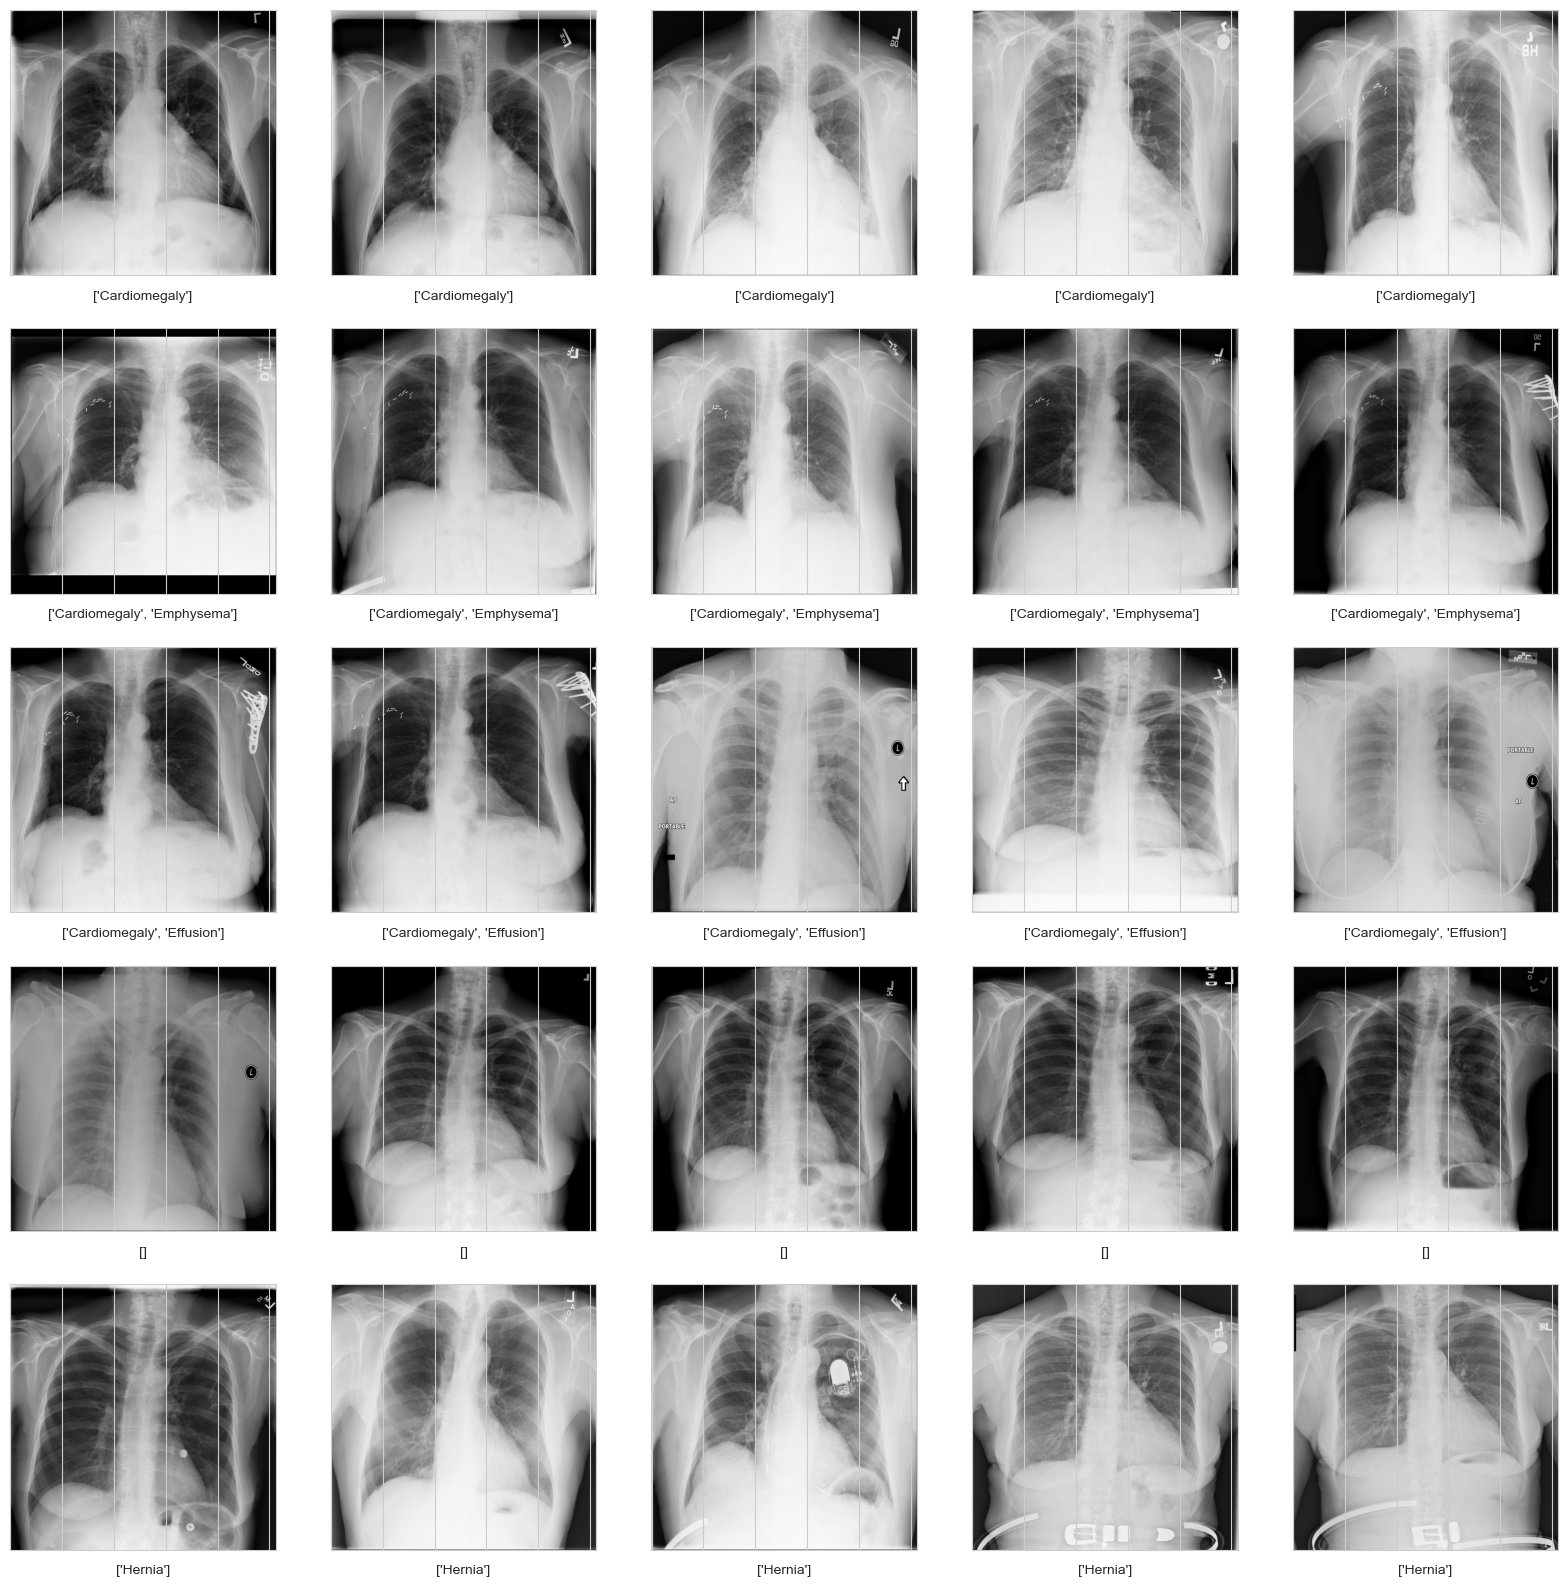

In [18]:
plot_images(data, 5, 5)

In [19]:
data1 = pd.read_csv('BBox_List_2017.csv')

In [20]:
data1 = data1[['Image Index', 'Finding Label', 'Bbox [x', 'y', 'w', 'h]']]

In [21]:
data1_image_paths = {os.path.basename(x): x for x in
                   glob(os.path.join('images*', '*', '*.png'))}
# print('Scans found:', len(data1_image_paths), ', Total Headers', data1.shape[0])
data1['path'] = data1['Image Index'].map(data1_image_paths.get)
data1['Finding Label'] = data1['Finding Label'].map(lambda x: x.replace('No Finding', ''))

In [22]:
data1.head()

,Image Index,Finding Label,Bbox [x,y,w,h],path
0,00013118_008.png,Atelectasis,225.084746,547.019217,86.779661,79.186441,images_006\images\00013118_008.png
1,00014716_007.png,Atelectasis,686.101695,131.543498,185.491525,313.491525,images_007\images\00014716_007.png
2,00029817_009.png,Atelectasis,221.830508,317.053115,155.118644,216.949153,images_012\images\00029817_009.png
3,00014687_001.png,Atelectasis,726.237288,494.951420,141.016949,55.322034,images_007\images\00014687_001.png
4,00017877_001.png,Atelectasis,660.067797,569.780787,200.677966,78.101695,images_008\images\00017877_001.png


In [23]:
def plot_images_with_bbox(data1, rows, columns, figsize=(20, 20)):
    """
    Function to plot images with bounding boxes
    """
    fig, axs = plt.subplots(rows, columns, figsize=figsize)
    idx = 0
    for i in range(rows):
        for j in range(columns):
            image_path = data1["path"].values[idx]
            image = np.asarray(Image.open(image_path).convert("RGB"))
            finding_labels = data1["Finding Label"].values[idx]

            if isinstance(finding_labels, str):
                labels = finding_labels.split("|")
            else:
                labels = []

            x = data1["Bbox [x"].values[idx]
            y = data1["y"].values[idx]
            width = data1["w"].values[idx]
            height = data1["h]"].values[idx]

            axs[i, j].imshow(image)
        
            rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='r', facecolor='none')
            axs[i, j].add_patch(rect)

            axs[i, j].yaxis.set_visible(False)
            axs[i, j].set_xticklabels([])
            axs[i, j].set_xlabel(labels)
            idx += 1

    plt.show()

In [24]:
print(data1.columns)

Index(['Image Index', 'Finding Label', 'Bbox [x', 'y', 'w', 'h]', 'path'], dtype='object')


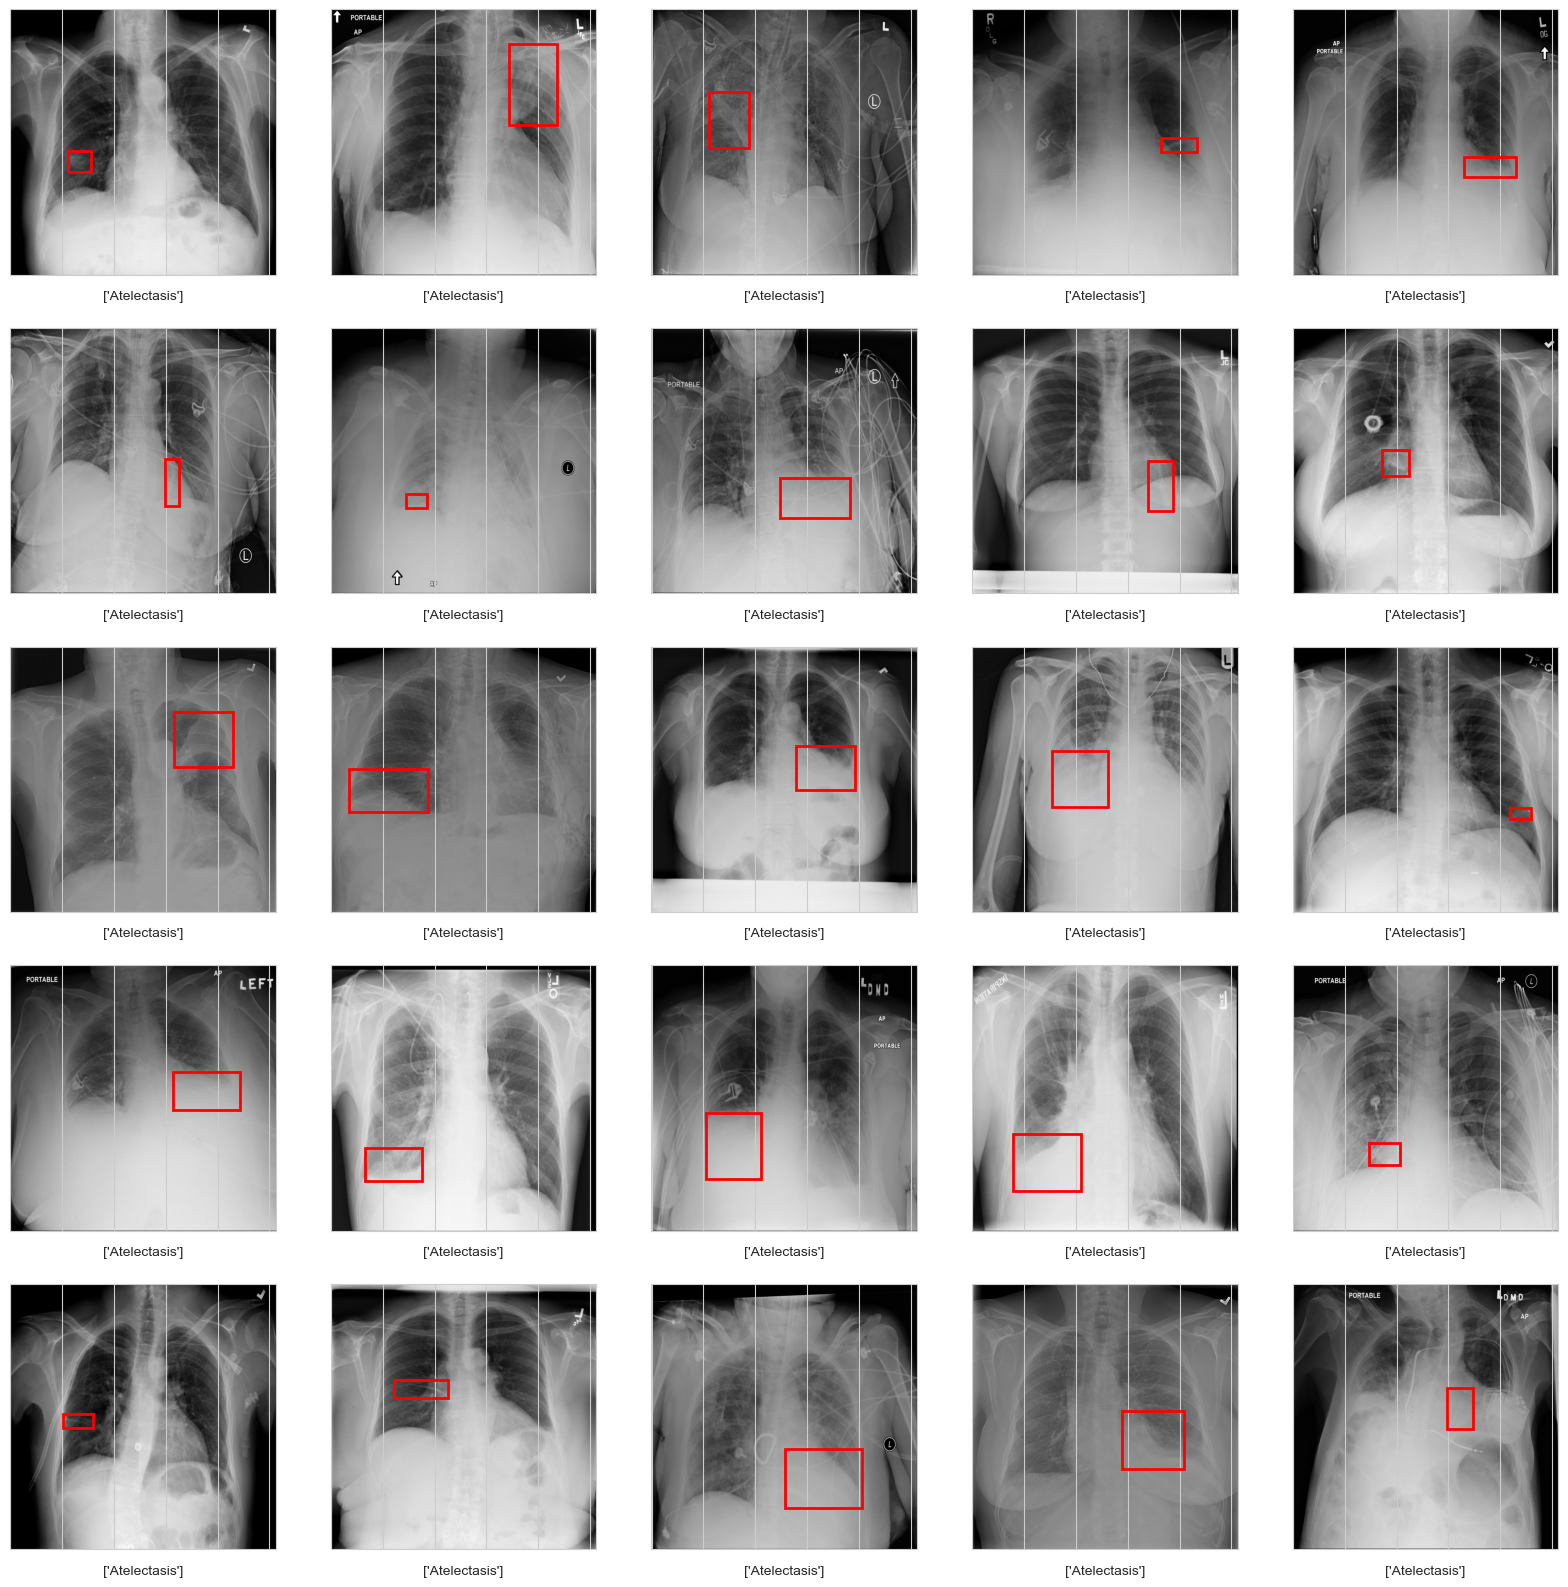

In [25]:
# Exemplo de uso
# Certifique-se de que as colunas 'x_coordinate', 'y_coordinate', 'width', 'height' existam em seu DataFrame
plot_images_with_bbox(data1, 5, 5)

In [26]:
class CheXNetData(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __getitem__(self, idx):
        image_path = self.data["path"].values[idx]
        image = Image.open(image_path).convert("RGB")

        # Redimensiona a imagem para o tamanho desejado
        image = image.resize((224, 224))

        labels_str = self.data.iloc[idx, 2]  # Assumindo que os rótulos estão na terceira coluna
        labels = [1 if label in labels_str else 0 for label in CFG.CLASS_NAMES]

        if self.transform:
            image = self.transform(image=np.asarray(image))["image"]

        # Converta label para tensor
        label = torch.tensor(labels, dtype=torch.float)

        return image, label

    def __len__(self):
        return len(self.data)

In [27]:
transforms = A.Compose(transforms=[A.Normalize(), ToTensorV2()])

In [28]:
ds = CheXNetData(data=data, transform=transforms)

In [29]:
image, label = ds[0]

In [30]:
image.size(), label.size()

(torch.Size([3, 224, 224]), torch.Size([14]))

In [30]:
total = len(ds)
train_len = int(0.8 * total)
val_len = total - train_len

train_ds, test_ds = random_split(dataset=ds, lengths=[train_len, val_len])

In [31]:
total = len(train_ds)
train_len = int(0.8 * total)
val_len = total - train_len

train_ds, val_ds = random_split(dataset=train_ds, lengths=[train_len, val_len])

In [33]:
print(f"Os comprimentos do conjunto de dados train, val e test: {len(train_ds)} imagens, {len(val_ds)} imagens e {len(test_ds)} imagens")

Os comprimentos do conjunto de dados train, val e test: 71756 imagens, 17940 imagens e 22424 imagens


In [35]:
ds_size = {
    "train": len(train_ds), "val": len(val_ds), "test": len(test_ds)
} 

In [36]:
ds_size

{'train': 71756, 'val': 17940, 'test': 22424}

In [37]:
loaders = {
    "train": DataLoader(train_ds, batch_size=64, shuffle=True),
    "val": DataLoader(val_ds, batch_size=32),
    "test": DataLoader(test_ds, batch_size=32)
}

In [38]:
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x22b13443d50>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x22b052e2450>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x22b052de590>}

In [39]:
class DenseNet121(nn.Module):
    def __init__(self, n_classes):
        super(DenseNet121, self).__init__()

        self.densenet121 = densenet121(pretrained=True)
        n_features = self.densenet121.classifier.in_features
        self.densenet121.classifier = nn.Sequential(
            nn.Linear(n_features, n_classes), nn.Sigmoid()
        )

    def forward(self, x):
        x = self.densenet121(x)
        return x

In [40]:
ds_batches = {k : len(v) for k, v in loaders.items()}
ds_batches

{'train': 1122, 'val': 561, 'test': 701}

In [41]:
# check is models folder exists
Path("models").mkdir(exist_ok=True)

# # Set up logger
# logging.basicConfig(
#     filename="train.log",
#     format="%(asctime)s - %(levelname)s - %(message)s",
#     level=logging.INFO,
#     filemode="w",
# )

In [42]:
def calc_mean_auc(labels: torch.tensor, preds: torch.tensor):
    labels = labels.cpu().detach().numpy()
    preds = preds.cpu().detach().numpy()
    
    per_class_AUROC = []
    for i, name in enumerate(CFG.CLASS_NAMES):
        try:
             per_class_AUROC.append(roc_auc_score(labels[:, i], preds[:, i]))
        except ValueError:
            pass
    mean_roc_auc = np.array(per_class_AUROC).mean()
    
    return mean_roc_auc

In [43]:
best_AUROC = 0.0 # Global AUROC

def run_one_epoch(
    epoch: int,
    ds_sizes: Dict[str, int],
    dataloaders: Dict[str, DataLoader],
    model: nn.Module,
    optimizer: torch.optim.Optimizer,
    loss: nn.Module,
    scheduler: torch.optim.lr_scheduler
):
    """
    Run one complete train-val loop

    Parameter
    ---------

    ds_sizes: Dictionary containing dataset sizes
    dataloaders: Dictionary containing dataloaders
    model: The model
    optimizer: The optimizer
    loss: The loss

    Returns
    -------

    metrics: Dictionary containing metrics

    """
    global best_AUROC
    
    metrics = {}
    AUROCs = []
    
    for phase in ["train", "val"]:
        logging.info(f"{phase.upper()} phase")

        if phase == "train":
            model.train()
        else:
            model.eval()
        
        avg_loss = 0
        running_corrects = 0

        for batch_idx, (images, labels) in enumerate(
            tqdm(dataloaders[phase], total=len(dataloaders[phase]))
        ):

            images = images.to(CFG.DEVICE)
            labels = labels.to(CFG.DEVICE)

            # Zero the gradients
            optimizer.zero_grad()

            # Track history if in phase == "train"
            with torch.set_grad_enabled(phase == "train"):
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                # print("Labels:", labels)
                # print("Outputs:", outputs)

                if phase == "train":
                    loss.backward()
                    optimizer.step()
                
                # Calculate AUROC
                auroc = calc_mean_auc(labels, outputs)
                AUROCs.append(auroc)

            avg_loss += loss.item() * images.size(0)

            if batch_idx % CFG.INTERVAL == 0:
                logging.info(
                    f"Epoch {epoch} - {phase.upper()} - Batch {batch_idx} - Loss = {round(loss.item(), 3)} | AUROC = {round(auroc, 3)}"
                )

        epoch_loss = avg_loss / ds_sizes[phase]
        epoch_val_mean = np.array(AUROCs).mean()
        
        # step the scheduler
        if phase == "train":
            scheduler.step(epoch_loss)
        
        # save best model wts
        if phase == "val" and epoch_val_mean > best_AUROC:
            best_AUROC = epoch_val_mean
            best_model_wts = deepcopy(model.state_dict())
            timestampTime = time.strftime("%H%M%S")
            timestampDate = time.strftime("%d%m%Y")
            timestampEND = timestampDate + '-' + timestampTime
            best_model_path = f"models/CheXNet-{timestampEND}.pt"
            torch.save({
                "epoch" : epoch, "val_loss": epoch_loss, "val_AUROC": epoch_val_mean, "model": best_model_wts
            }, best_model_path)

        # Metrics tracking
        if phase == "train":
            metrics["train_loss"] = round(epoch_loss, 3)
        else:
            metrics["val_loss"] = round(epoch_loss, 3)
            metrics["val_mean_AUROC"] = round(epoch_val_mean, 3)

    return metrics

In [44]:
def train(dataloaders, ds_sizes, model, optimizer, criterion, scheduler):
    table = PrettyTable(
        field_names=["Epoch", "Train Loss", "Val Loss", "Val Mean AUROC"]
    )

    if torch.cuda.device_count() > 1:
        print("Using", torch.cuda.device_count(), "GPUs!")
        model = torch.nn.DataParallel(model)
    
    for epoch in range(CFG.EPOCHS):

        start = time.time()

        metrics = run_one_epoch(
            epoch=epoch,
            ds_sizes=ds_sizes,
            dataloaders=dataloaders,
            model=model,
            optimizer=optimizer,
            loss=criterion,
            scheduler=scheduler
        )

        end = time.time() - start

        print(f"Epoch completed in: {round(end/60, 3)} mins")

        table.add_row(
            row=[
                epoch + 1,
                metrics["train_loss"],
                metrics["val_loss"],
                metrics["val_mean_AUROC"]
            ]
        )
        print(table)

    # Write results to file
    with open("results.txt", "w") as f:
        results = table.get_string()
        f.write(results)

In [45]:
model = DenseNet121(n_classes=14).to(CFG.DEVICE)
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, mode='min', patience=1)

c:\Users\mikha\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\mikha\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [45]:
train(
    dataloaders=loaders, 
    ds_sizes=ds_size, 
    model=model, 
    optimizer=optimizer, 
    criterion=criterion, 
    scheduler=scheduler
)

  0%|          | 0/1122 [00:00<?, ?it/s]

In [ ]:
with torch.no_grad():
    model.eval()
    out_gt = torch.FloatTensor()
    out_pred = torch.FloatTensor()
    for images, labels in tqdm(loaders["test"]):
        images = images.to(CFG.DEVICE)
        labels = labels.to(CFG.DEVICE)
        
        outputs = model(images)
        outputs = outputs.cpu().detach()
        
        out_gt = torch.cat((out_gt, labels.cpu().detach()), 0)
        out_pred = torch.cat((out_pred, outputs.data), 0)

In [ ]:
labels = out_gt.numpy()
preds = out_pred.numpy()

per_class_AUROC = []

print("-----PER - CLASS AUROC------")

for i, name in enumerate(CFG.CLASS_NAMES):
    try:
        if len(np.unique(labels[:, i])) > 1:
            auroc = round(roc_auc_score(labels[:, i], preds[:, i]), 3)
            print(f"{name} - {auroc}")
            per_class_AUROC.append(auroc)
        else:
            print(f"Skipping AUROC calculation for {name}: Only one class present in y_true.")
    except ValueError as e:
        print(f"Error calculating AUROC for {name}: {e}")

# mean_roc_auc = np.array(per_class_AUROC).mean()


In [ ]:
def calculate_accuracy(model, dataloader, device):
    model.eval()
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    accuracy = correct_predictions / total_samples
    return accuracy

# Use a função para calcular a acurácia no conjunto de validação, por exemplo
accuracy = calculate_accuracy(model, loaders['val'], CFG.DEVICE)
print(f'Accuracy on validation set: {accuracy:.4f}')